# BERTopic: Topic Modelling for Social Media Data 📱


BERTopic is a topic modelling technique that utilises transformer-based embeddings, such as those from BERT (Bidirectional Encoder Representations from Transformers), to identify and represent topics within a collection of documents.

The pipeline can be broken down into 6 steps as in the image below. It begins by converting text data into embeddings that capture contextual relationships between words. These embeddings are then reduced in dimensionality, which helps in clustering similar documents more efficiently. Following dimensionality reduction, the embeddings are clustered using an algorithm such as HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise), grouping documents into topics based on their semantic similarity. Each cluster or group of documents represents a potential topic. Finally, BERTopic employs a class-based TF-IDF (Term Frequency-Inverse Document Frequency) to identify the most representative words of each topic, thereby creating a descriptive label for each identified topic. This method allows for a more nuanced and contextually relevant understanding of text data compared to traditional topic modelling approaches.

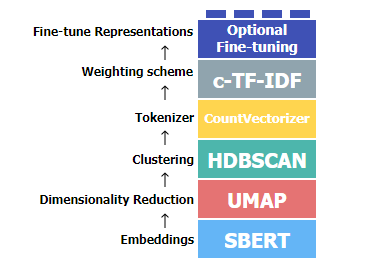...

The graphic above is used to illustrate the modularity of BERTopic and is helpful to communicate the sequence of steps taken. Because the pipeline is modular by design, the actual methods and algorithms used can be adapted to the current state-of-the-art.

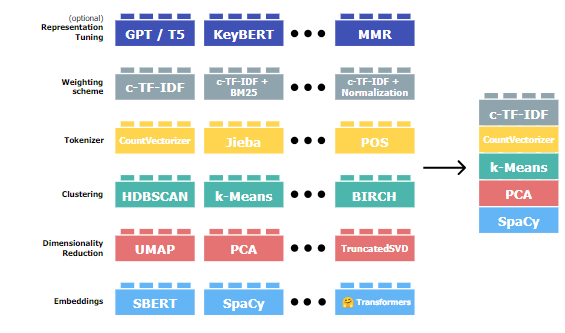


## Setup

In [ ]:
%%capture
!pip install bertopic
!pip install openai
!pip install sentence-transformers

## Data

For this example, uplaod the extarcted sentences from the KSE app.

In [ ]:
import pandas as pd
hsbc_2023 = pd.read_csv("hsbc-2023-key-sentences.csv")

Sentence splitter

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
key_sentences_list = hsbc_2023['Sentence'].tolist()
key_sentences_string = '. '.join(key_sentences_list)
sentences = sent_tokenize(key_sentences_string)

## Create sentence embeddings

Create sentence embeddings from the document abstracts

In [ ]:
from sentence_transformers import SentenceTransformer

# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(sentences, show_progress_bar=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

## Dimensionality reduction

To reduce the size of the embeddings we can use a dimensionality reduction technique such as UMAP. By default, UMAP (Uniform Manifold Approximation & Projection) shows stochastic behaviour but we can avoid this by specifying the random state.

In [ ]:
from umap import UMAP

umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

## Clustering

In [ ]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

## Tokeniser

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

## Create topics

In creating the topics, we can finetune the embedding model to extract different representations of topics. Some of these representation models are described below:

* KeyBERT - finds subphrases in a document that best represent the document itself, using BERT-embeddings and cosing similarity.
* Part-of-Speech (POS) - generates new candidate keywords for each topic based on existing documents that contain a keyword.
* Marginal Maximal Relevance (MMR) - aims to maximise diversity of keywords and phrases by considering the similarity of keywords and phrases within a document.
* OpenAI GPT-4 - using prompting to produce a short topic description based on aleady identified key words and phrases.

In [ ]:
import openai
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, OpenAI, PartOfSpeech
from google.colab import userdata

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# GPT-4
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
I have a topic that is described by the following keywords: [KEYWORDS]. These keywords have been extracted from key sentences within a financial document.

Based on the information above, extract a short but highly descriptive topic label of at most 6 words. Make sure it is in the following format:
topic: <topic label>
"""
client = openai.OpenAI(api_key=userdata.get("OpenAI2"))
openai_model = OpenAI(client, model="gpt-4", exponential_backoff=True, chat=True, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "OpenAI": openai_model,
    "MMR": mmr_model,
    "POS": pos_model
}

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=20,
  verbose=True
)

topics, probs = topic_model.fit_transform(sentences, embeddings)

2024-04-18 13:14:37,326 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-18 13:14:38,280 - BERTopic - Dimensionality - Completed ✓
2024-04-18 13:14:38,282 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-18 13:14:38,292 - BERTopic - Cluster - Completed ✓
2024-04-18 13:14:38,297 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 6/6 [00:08<00:00,  1.37s/it]
2024-04-18 13:14:47,416 - BERTopic - Representation - Completed ✓


In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,OpenAI,MMR,POS,Representative_Docs
0,-1,31,-1_2023_net_growth_assets,"[2023, net, growth, assets, sector, wealth, ba...","[tangible equity, assets, estate sector, secto...",[Growth and Risk in 2023 Banking Sector],"[2023, growth, assets, sector, banking, global...","[net, growth, assets, sector, wealth, banking,...","[In addition, over half of WPB client acquisit..."
1,0,40,0_uk_hsbc_svb uk_svb,"[uk, hsbc, svb uk, svb, acquisition, banking, ...","[acquisition svb, svb uk, 6bn, currency basis,...",[HSBC's SVB UK Acquisition & France Operations...,"[hsbc, svb uk, acquisition, acquisition svb, i...","[acquisition, banking, tax, revenue, sale, yea...","[This included a number of notable items, incl..."
2,1,33,1_usd0_costs_revenue_higher,"[usd0, costs, revenue, higher, offset, related...","[operating expenses, expenses, usd0 2bn, usd0 ...",[Restructuring and Cost-Saving Programme Impact],"[usd0, costs, revenue, reduction, losses, expe...","[costs, revenue, higher, related, cost, restru...","[Additionally, the non-recurrence of restructu..."
3,2,31,2_stress_group_risk_financial,"[stress, group, risk, financial, capital, scen...","[stress, risk management, risk, risk exposures...",[Group's Financial Risk Management and Capital...,"[stress, risk, financial, capital, management,...","[stress, risk, financial, capital, scenario, r...",[The outcomes were used to identify challenges...
4,3,16,3_impairment_profit_share_associates,"[impairment, profit, share, associates, invest...","[impairment investment, investment bocom, prof...",[Impairment Impact on Bocom Investment 2023],"[impairment, profit, investment, bocom, invest...","[impairment, profit, share, associates, invest...","[It also includes Central Treasury, stewardshi..."
5,4,14,4_ratio_cet1_14_items,"[ratio, cet1, 14, items, capital, notable item...","[capital ratio, capital ratios, cet1 capital, ...",[CET1 Capital Ratio and 2024 Targets],"[ratio, capital, notable items, dividend, targ...","[ratio, items, capital, notable, notable items...",[Common equity tier 1 ('CET1') capital ratio o...


In [ ]:
topic_model

In [ ]:
topic_model.get_topic(1, full=True)

{'Main': [('usd0', 0.08539139503265746),
  ('costs', 0.05720520480384981),
  ('revenue', 0.05413193816749064),
  ('higher', 0.045748810869375704),
  ('offset', 0.045162003792513),
  ('related', 0.04467515567800068),
  ('cost', 0.04314319459109304),
  ('restructuring', 0.04187410405152415),
  ('lower', 0.038877391729632726),
  ('reduction', 0.038248544729896625),
  ('following', 0.03730763179951607),
  ('losses', 0.0359526621592442),
  ('programme', 0.03582200397359408),
  ('expenses', 0.03582200397359408),
  ('related costs', 0.03582200397359408),
  ('completion', 0.03582200397359408),
  ('operating expenses', 0.03582200397359408),
  ('restructuring related', 0.03582200397359408),
  ('partly', 0.035586673712683176),
  ('partly offset', 0.035586673712683176)],
 'KeyBERT': [('operating expenses', 0.5833865),
  ('expenses', 0.53966624),
  ('usd0 2bn', 0.51215935),
  ('usd0 3bn', 0.51098347),
  ('related costs', 0.49256152),
  ('restructuring related', 0.43550968),
  ('revenue', 0.41711718

## Topic distribution

In [ ]:
topic_distr, _ = topic_model.approximate_distribution(sentences, window=8, stride=4)

100%|██████████| 1/1 [00:00<00:00, 34.99it/s]


In [ ]:
# Visualise topic distribution for specific sentences
sentence_id = 20
print(sentences[sentence_id])
topic_model.visualize_distribution(topic_distr[sentence_id])

We delivered strong revenue growth across all three global businesses, supported by higher interest rates, which enabled us to deliver our best return on average tangible equity in more than a decade.


In [ ]:
# Visualise on the token level
# Calculate the topic distributions on a token-level
topic_distr, topic_token_distr = topic_model.approximate_distribution(sentences[sentence_id], calculate_tokens=True)

# Visualize the token-level distributions
df = topic_model.visualize_approximate_distribution(sentences[sentence_id], topic_token_distr[0])
df

100%|██████████| 1/1 [00:00<00:00, 205.80it/s]


,We,delivered,strong,revenue,growth,across,all,three,global,businesses,supported,by,higher,interest,rates,which,enabled,us,to,deliver,our,best,return,on,average,tangible,equity,in,more,than,decade
0_uk_hsbc_svb uk_svb,0.000,0.000,0.000,0.125,0.125,0.125,0.125,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1_usd0_costs_revenue_higher,0.000,0.000,0.000,0.165,0.165,0.165,0.165,0.000,0.000,0.000,0.000,0.131,0.261,0.261,0.261,0.131,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4_ratio_cet1_14_items,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.106,0.212,0.212,0.212,0.106,0.000,0.000,0.000


## Visualisation

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_hierarchy()